In [8]:
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.linear_model import LinearRegression

from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
import sklearn
from sklearn import pipeline, preprocessing, feature_extraction
import xgboost as xgb
from sklearn.metrics import f1_score
import xgboost as xgb

In [9]:
events = pd.DataFrame.from_csv("user_activity.csv",index_col=None)
structure = pd.DataFrame.from_csv("structure.csv",index_col=None)
targets = pd.DataFrame.from_csv("targets.csv",index_col=None)
events_test = pd.DataFrame.from_csv("user_activity_test.csv",index_col=None)

In [10]:
tmin1  = events.groupby('user_id').time.min()
tmax  = events.groupby('user_id').time.max()
tmin = tmax - tmin1

tmin1 = pd.DataFrame(tmin1)
tmin1.columns = ['start_time']
tmin1['user'] = tmin1.index

In [11]:
1202733.0 / (3600 * 24)

13.920520833333333

In [12]:
3600 * 15

54000

In [13]:
events[-10:]

,user_id,action,step_id,time,step_type,step_cost
2189845,4,discovered,41483,1465181906,text,0
2189846,4,passed,41483,1465181906,text,0
2189847,4,viewed,7322,1465182052,video,0
2189848,4,discovered,7322,1465182052,video,0
2189849,4,passed,7322,1465182052,video,0
2189850,1,viewed,39540,1465182117,code,1
2189851,1,viewed,44097,1465182653,choice,1
2189852,1,viewed,11077,1465182700,video,0
2189853,1,viewed,39540,1465182918,code,1
2189854,1,viewed,10192,1465182971,code,2


In [14]:
events.shape

(2189855, 6)

In [15]:
events_last_week = events

In [16]:
events_last_week = pd.merge(events_last_week, tmin1, left_on='user_id', right_on='user', how='outer')

In [17]:
events_last_week.shape

(2189855, 8)

In [18]:
7 * 3600 * 24

604800

In [19]:
events_last_week = events_last_week[events_last_week.time > events_last_week.start_time + 604800]

In [20]:
events_last_week.shape

(498985, 8)

In [21]:
H_last = events_last_week.groupby('user_id') \
                    .apply(lambda x: x[['step_type']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)

In [22]:
H_last.shape

(4211, 6)

In [23]:
H = events.groupby('user_id') \
                    .apply(lambda x: x[['step_type']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)

In [24]:
H.shape

(16625, 6)

In [25]:
H_last['user_last'] = H_last.index

In [26]:
H_last[:4]

,choice,code,number,string,text,video,user_last
user_id,,,,,,,
7,0.0,12.0,4.0,0.0,0.0,0.0,7
13,0.0,0.0,0.0,0.0,16.0,0.0,13
14,1.0,80.0,8.0,0.0,106.0,177.0,14
17,22.0,14.0,3.0,0.0,45.0,88.0,17


In [27]:
steps = structure.step_id
steps = steps.tolist()

In [28]:
pasted_events = events[events.action == 'passed']

In [29]:
S = pasted_events.groupby('user_id') \
                    .apply(lambda x: x[['step_id']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)

In [30]:
S[:10]

,2681,2682,2687,2688,2689,2690,2691,2692,2693,2694,...,43608,44097,44160,44167,44174,44313,54850,84377,84530,84531
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
S = S[steps]

In [32]:
H['skip'] = -1

In [33]:
H['skip_part'] = 0

In [34]:
su = 0
k = 0
flag = 0
for i in S.index:
    for j in S.ix[i,:]:
        if j == 0 and flag == 1:
            flag = 0
            su += 1
        if j == 1 and flag == 0:
            flag = 1
    H.ix[i, 'skip'] = su
    su = 0
    flag = 0


In [35]:
su = 0
k = 0
flag = 0
tmp_su = 0
for i in S.index:
    ones = 0
    su = 0
    tmp_su = 0
    flag = 0
    for j in S.ix[i,:]:
        if j == 0 and flag == 1:
            flag = 0
            tmp_su = 1
        if j == 0 and flag == 0:
            tmp_su += 1
        if j == 1 and flag == 0:
            flag = 1
            su += tmp_su
            tmp_su = 0
        if j == 1:
            ones += 1  
        t = su / (su + ones + 0.00000000001) * 1.0
    H.ix[i, 'skip_part'] = t

In [36]:
A = events.groupby('user_id') \
                    .apply(lambda x: x[['action']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)

In [37]:
A['user'] = A.index

In [38]:
A[:4]

,discovered,passed,started_attempt,viewed,user
user_id,,,,,
1,322.0,254.0,0.0,1371.0,1
2,9.0,9.0,0.0,11.0,2
3,31.0,31.0,21.0,46.0,3
4,66.0,66.0,24.0,105.0,4


In [39]:
A = pd.concat([A, H],axis=1)

In [40]:
tmin = pd.DataFrame(tmin)
tmin.columns = ['period']

In [41]:
A = pd.concat([A, tmin],axis=1)

In [42]:
A[:4]

,discovered,passed,started_attempt,viewed,user,choice,code,number,string,text,video,skip,skip_part,period
user_id,,,,,,,,,,,,,,
1,322.0,254.0,0.0,1371.0,1,104.0,410.0,34.0,6.0,475.0,918.0,50,0.371287,488967
2,9.0,9.0,0.0,11.0,2,0.0,0.0,0.0,0.0,14.0,15.0,4,0.887500,97
3,31.0,31.0,21.0,46.0,3,42.0,8.0,0.0,0.0,72.0,7.0,11,0.915068,413917
4,66.0,66.0,24.0,105.0,4,49.0,12.0,0.0,0.0,66.0,134.0,1,0.000000,399001


In [43]:
H_last.shape

(4211, 7)

In [44]:
A.shape

(16625, 14)

In [45]:
A = pd.merge(A, H_last, left_on='user', right_on='user_last', how='outer')

In [46]:
A.shape

(16625, 21)

In [47]:
A.index = A.user
A[:7]

,discovered,passed,started_attempt,viewed,user,choice_x,code_x,number_x,string_x,text_x,...,skip,skip_part,period,choice_y,code_y,number_y,string_y,text_y,video_y,user_last
user,,,,,,,,,,,,,,,,,,,,,
1,322.0,254.0,0.0,1371.0,1,104.0,410.0,34.0,6.0,475.0,...,50,0.371287,488967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.0,9.0,0.0,11.0,2,0.0,0.0,0.0,0.0,14.0,...,4,0.887500,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31.0,31.0,21.0,46.0,3,42.0,8.0,0.0,0.0,72.0,...,11,0.915068,413917,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,66.0,66.0,24.0,105.0,4,49.0,12.0,0.0,0.0,66.0,...,1,0.000000,399001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,106.0,106.0,27.0,198.0,6,39.0,65.0,9.0,0.0,120.0,...,1,0.000000,201220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,72.0,64.0,13.0,106.0,7,32.0,20.0,4.0,0.0,87.0,...,14,0.597484,608322,0.0,12.0,4.0,0.0,0.0,0.0,7.0
8,55.0,55.0,16.0,57.0,8,36.0,8.0,0.0,0.0,48.0,...,1,0.000000,36571,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
sum_score = pasted_events.groupby('user_id')['step_cost'].apply(lambda x: sum(x))
sum_score = pd.DataFrame(sum_score)
sum_score.columns = ['sum_score']

In [49]:
A = pd.concat([A, sum_score],axis=1)

In [50]:
pasted_events_last = events_last_week[events_last_week.action == 'passed']

In [51]:
sum_score = pasted_events_last.groupby('user_id')['step_cost'].apply(lambda x: sum(x))
sum_score = pd.DataFrame(sum_score)
sum_score.columns = ['sum_score_last']

In [52]:
sum_score['user'] = sum_score.index
sum_score[:4]

,sum_score_last,user
user_id,,
7,1,7
14,11,14
20,5,20
22,4,22


In [53]:
A = pd.merge(A, sum_score, left_on='user', right_on='user', how='outer')

In [54]:
A[:7]

,discovered,passed,started_attempt,viewed,user,choice_x,code_x,number_x,string_x,text_x,...,period,choice_y,code_y,number_y,string_y,text_y,video_y,user_last,sum_score,sum_score_last
0,322.0,254.0,0.0,1371.0,1,104.0,410.0,34.0,6.0,475.0,...,488967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,9.0,9.0,0.0,11.0,2,0.0,0.0,0.0,0.0,14.0,...,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,31.0,31.0,21.0,46.0,3,42.0,8.0,0.0,0.0,72.0,...,413917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN
3,66.0,66.0,24.0,105.0,4,49.0,12.0,0.0,0.0,66.0,...,399001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN
4,106.0,106.0,27.0,198.0,6,39.0,65.0,9.0,0.0,120.0,...,201220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN
5,72.0,64.0,13.0,106.0,7,32.0,20.0,4.0,0.0,87.0,...,608322,0.0,12.0,4.0,0.0,0.0,0.0,7.0,6.0,1.0
6,55.0,55.0,16.0,57.0,8,36.0,8.0,0.0,0.0,48.0,...,36571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN


In [55]:
A.shape

(16625, 23)

In [56]:
A_last = events_last_week.groupby('user_id') \
                    .apply(lambda x: x[['action']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)

In [57]:
A_last['user'] = A_last.index
A_last[:4]

,discovered,passed,started_attempt,viewed,user
user_id,,,,,
7,5.0,1.0,4.0,6.0,7
13,0.0,0.0,0.0,16.0,13
14,48.0,47.0,13.0,264.0,14
17,0.0,0.0,16.0,156.0,17


In [58]:
A = pd.merge(A, A_last, left_on='user', right_on='user', how='outer')

In [59]:
A[:7]

,discovered_x,passed_x,started_attempt_x,viewed_x,user,choice_x,code_x,number_x,string_x,text_x,...,string_y,text_y,video_y,user_last,sum_score,sum_score_last,discovered_y,passed_y,started_attempt_y,viewed_y
0,322.0,254.0,0.0,1371.0,1,104.0,410.0,34.0,6.0,475.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,9.0,9.0,0.0,11.0,2,0.0,0.0,0.0,0.0,14.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,31.0,31.0,21.0,46.0,3,42.0,8.0,0.0,0.0,72.0,...,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN
3,66.0,66.0,24.0,105.0,4,49.0,12.0,0.0,0.0,66.0,...,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN
4,106.0,106.0,27.0,198.0,6,39.0,65.0,9.0,0.0,120.0,...,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN
5,72.0,64.0,13.0,106.0,7,32.0,20.0,4.0,0.0,87.0,...,0.0,0.0,0.0,7.0,6.0,1.0,5.0,1.0,4.0,6.0
6,55.0,55.0,16.0,57.0,8,36.0,8.0,0.0,0.0,48.0,...,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN


In [60]:
A.shape

(16625, 27)

In [61]:
perc = A.passed_x / A.discovered_x * 1.0
perc = pd.DataFrame(perc, columns = ['perc']) 
A = pd.concat([A, perc],axis=1)
A.fillna(0, inplace = True)

In [62]:
A.index = A.user
A[:5]

,discovered_x,passed_x,started_attempt_x,viewed_x,user,choice_x,code_x,number_x,string_x,text_x,...,text_y,video_y,user_last,sum_score,sum_score_last,discovered_y,passed_y,started_attempt_y,viewed_y,perc
user,,,,,,,,,,,,,,,,,,,,,
1,322.0,254.0,0.0,1371.0,1,104.0,410.0,34.0,6.0,475.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.78882
2,9.0,9.0,0.0,11.0,2,0.0,0.0,0.0,0.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000
3,31.0,31.0,21.0,46.0,3,42.0,8.0,0.0,0.0,72.0,...,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,1.00000
4,66.0,66.0,24.0,105.0,4,49.0,12.0,0.0,0.0,66.0,...,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,1.00000
6,106.0,106.0,27.0,198.0,6,39.0,65.0,9.0,0.0,120.0,...,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,1.00000


In [63]:
def count_work_5(x):
    count = 0
    last = -1000000
    i = 0
    for elem in x:
        if i != len(x):
            if elem - last > 18000:
                count = count + 1
        last = elem
        i = i + 1
    return count

In [64]:
3600 * 36

129600

In [65]:
count_5 = events.groupby('user_id')['time'].apply(lambda x: count_work_5(x))
count_5 = pd.DataFrame(count_5)
count_5.columns = ['count_5']


In [66]:
count_5[:5]

,count_5
user_id,
1,1
2,1
3,3
4,9
6,3


In [67]:
A = pd.concat([A, count_5],axis=1)

In [68]:
A.shape

(16625, 29)

In [192]:
A[A.sum_score > 91]

,discovered_x,passed_x,started_attempt_x,viewed_x,choice_x,code_x,number_x,string_x,text_x,video_x,...,sum_score,sum_score_last,discovered_y,passed_y,started_attempt_y,viewed_y,perc,count_5,time_period,time_sum
user,,,,,,,,,,,,,,,,,,,,,
176,324.0,323.0,89.0,520.0,99.0,186.0,32.0,6.0,260.0,673.0,...,101.0,12.0,29.0,29.0,9.0,61.0,0.996914,14,13886.0,194406.0
309,339.0,337.0,83.0,388.0,87.0,186.0,34.0,5.0,235.0,600.0,...,109.0,41.0,92.0,92.0,30.0,119.0,0.994100,11,14516.0,159682.0
698,333.0,330.0,137.0,729.0,157.0,271.0,33.0,7.0,339.0,722.0,...,102.0,42.0,110.0,107.0,69.0,340.0,0.990991,17,16165.0,274817.0
961,354.0,354.0,99.0,579.0,89.0,289.0,32.0,5.0,280.0,691.0,...,119.0,0.0,0.0,0.0,0.0,1.0,1.000000,9,26752.0,240771.0
2224,317.0,322.0,126.0,688.0,121.0,235.0,33.0,4.0,289.0,771.0,...,95.0,31.0,85.0,88.0,32.0,208.0,1.015773,17,20990.0,356842.0
3092,354.0,354.0,94.0,475.0,95.0,198.0,32.0,4.0,306.0,642.0,...,119.0,0.0,0.0,0.0,0.0,0.0,1.000000,9,19568.0,176119.0
3337,308.0,305.0,93.0,475.0,124.0,190.0,36.0,5.0,236.0,590.0,...,96.0,0.0,0.0,0.0,0.0,0.0,0.990260,10,14998.0,149982.0
4814,337.0,334.0,139.0,532.0,143.0,248.0,47.0,8.0,283.0,613.0,...,115.0,36.0,65.0,68.0,48.0,160.0,0.991098,11,19154.0,210701.0
4818,354.0,354.0,97.0,529.0,104.0,221.0,34.0,4.0,277.0,694.0,...,119.0,0.0,0.0,0.0,0.0,0.0,1.000000,8,19766.0,158133.0


In [70]:
def ave_time(x):
    count = 1
    last = 0
    i = 0
    start = 0
    end = 0
    ave_sum = 0
    for elem in x:
        if i != len(x):
            if i == 0:
                start = elem
                last = elem
            else:
                if elem - last > 18000:
                    end = last
                    ave_sum += (end - start)
                    start = elem
                    count = count + 1 
        last = elem
        i = i + 1
    t = ave_sum / count * 1.0
    return t

In [72]:
3600*5

18000

In [73]:
time_period = events.groupby('user_id')['time'].apply(lambda x: ave_time(x))
time_period = pd.DataFrame(time_period)
time_period.columns = ['time_period']

In [74]:
A = pd.concat([A, time_period],axis=1)

In [76]:
A.shape

(16625, 31)

In [77]:
A.fillna(0, inplace = True)
A[:10]

,discovered_x,passed_x,started_attempt_x,viewed_x,user,choice_x,code_x,number_x,string_x,text_x,...,sum_score,sum_score_last,discovered_y,passed_y,started_attempt_y,viewed_y,perc,count_5,time_period,time_sum
user,,,,,,,,,,,,,,,,,,,,,
1,322.0,254.0,0.0,1371.0,1,104.0,410.0,34.0,6.0,475.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.788820,1,0.0,0.0
2,9.0,9.0,0.0,11.0,2,0.0,0.0,0.0,0.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1,0.0,0.0
3,31.0,31.0,21.0,46.0,3,42.0,8.0,0.0,0.0,72.0,...,9.0,0.0,0.0,0.0,0.0,0.0,1.000000,3,1196.0,3590.0
4,66.0,66.0,24.0,105.0,4,49.0,12.0,0.0,0.0,66.0,...,9.0,0.0,0.0,0.0,0.0,0.0,1.000000,9,4877.0,43894.0
6,106.0,106.0,27.0,198.0,6,39.0,65.0,9.0,0.0,120.0,...,26.0,0.0,0.0,0.0,0.0,0.0,1.000000,3,5829.0,17487.0
7,72.0,64.0,13.0,106.0,7,32.0,20.0,4.0,0.0,87.0,...,6.0,1.0,5.0,1.0,4.0,6.0,0.888889,4,2480.0,9921.0
8,55.0,55.0,16.0,57.0,8,36.0,8.0,0.0,0.0,48.0,...,9.0,0.0,0.0,0.0,0.0,0.0,1.000000,2,154.0,309.0
10,28.0,28.0,7.0,33.0,10,18.0,0.0,0.0,0.0,35.0,...,3.0,0.0,0.0,0.0,0.0,0.0,1.000000,1,0.0,0.0
11,1.0,1.0,0.0,1.0,11,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1,0.0,0.0


In [78]:
A.columns.unique

<bound method Index.unique of Index([u'discovered_x', u'passed_x', u'started_attempt_x', u'viewed_x',
       u'user', u'choice_x', u'code_x', u'number_x', u'string_x', u'text_x',
       u'video_x', u'skip', u'skip_part', u'period', u'choice_y', u'code_y',
       u'number_y', u'string_y', u'text_y', u'video_y', u'user_last',
       u'sum_score', u'sum_score_last', u'discovered_y', u'passed_y',
       u'started_attempt_y', u'viewed_y', u'perc', u'count_5', u'time_period',
       u'time_sum'],
      dtype='object')>

In [79]:
#A = A[['sum_score', 'period', 'perc', 'passed', 'time_period', 'viewed', 'text', 'count_10']]

In [80]:
del A['user']
del A['user_last']

In [81]:
features = []
for i in A.columns:
    features += [i]

In [82]:
users = A.index
users.shape

(16625,)

In [83]:
y = targets.score
ind = targets.user_id
y = pd.DataFrame(y)
y.index = ind

In [298]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(A, y)
A_scaled = scaler.transform(A)
A_scaled = pd.DataFrame(A_scaled, columns = features)
A_scaled.index = users

In [299]:
A_scaled[:4]

,discovered_x,passed_x,started_attempt_x,viewed_x,choice_x,code_x,number_x,string_x,text_x,video_x,...,sum_score,sum_score_last,discovered_y,passed_y,started_attempt_y,viewed_y,perc,count_5,time_period,time_sum
user,,,,,,,,,,,,,,,,,,,,,
1,6.454864,5.091881,-0.541558,12.759889,3.971266,12.149705,7.103748,9.967881,8.021377,8.679873,...,-0.475626,-0.311063,-0.355144,-0.353553,-0.271543,-0.289451,-1.019345,-0.567737,-0.528211,-0.419137
2,-0.527094,-0.518239,-0.541558,-0.449576,-0.700249,-0.373019,-0.366627,-0.092179,-0.509807,-0.462125,...,-0.475626,-0.311063,-0.355144,-0.353553,-0.271543,-0.289451,0.340447,-0.567737,-0.528211,-0.419137
3,-0.036349,-0.014473,0.576454,-0.109626,1.186324,-0.128673,-0.366627,-0.092179,0.563531,-0.543117,...,0.432017,-0.311063,-0.355144,-0.353553,-0.271543,-0.289451,0.340447,0.017024,-0.230780,-0.316567
4,0.744381,0.786972,0.736170,0.463431,1.500753,-0.006500,-0.366627,-0.092179,0.452496,0.742634,...,0.432017,-0.311063,-0.355144,-0.353553,-0.271543,-0.289451,0.340447,1.771306,0.684643,0.834963


In [219]:
A_scaled.columns.unique

<bound method Index.unique of Index([u'discovered_x', u'passed_x', u'started_attempt_x', u'viewed_x',
       u'choice_x', u'code_x', u'number_x', u'string_x', u'text_x', u'video_x',
       u'skip', u'skip_part', u'period', u'choice_y', u'code_y', u'number_y',
       u'string_y', u'text_y', u'video_y', u'sum_score', u'sum_score_last',
       u'discovered_y', u'passed_y', u'started_attempt_y', u'viewed_y',
       u'perc', u'count_5', u'time_period', u'time_sum'],
      dtype='object')>

In [269]:
#A_scaled = A_scaled[['discovered_x', 'passed_x', 'started_attempt_x',
#                    'viewed_x', 'choice_x', 'code_x', 'number_x', 'string_x',
#                    'text_x', 'video_x', 'skip', 'skip_part', 'period', 'sum_score',
#                    'time_period', 'time_sum']]

In [300]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(A_scaled, y, 
                                                                                     test_size = 0.3)

In [301]:
test_bi = []
for i in test_labels.index.values:
    if test_labels.ix[i, 0] >= 91:
        test_bi += [1]
    else:
        test_bi += [0]

In [302]:
train_bi = []
for i in train_labels.index.values:
    if train_labels.ix[i, 0] >= 91:
        train_bi += [1]
    else:
        train_bi += [0]

In [181]:
train_labels.shape

(11637, 1)

# Задача классификации

In [89]:
logreg = sklearn.linear_model.LogisticRegression(penalty='l2',
                                        dual=False,
                                        tol=0.0001,
                                        C=1.0,
                                        fit_intercept=True,
                                        intercept_scaling=1,
                                        class_weight=None,
                                        random_state=None,
                                        solver='liblinear',
                                        max_iter=100,
                                        multi_class='ovr',
                                        verbose=0,
                                        warm_start=False,
                                        n_jobs=1)

In [90]:
logreg.fit(train_data, train_bi)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [91]:
logreg_pred = logreg.predict(test_data)

In [97]:
f1_score(test_bi, logreg_pred)

0.35820895522388058

In [100]:
xgb_cla = xgb.XGBClassifier(max_depth=3,
                      learning_rate=0.1,
                      n_estimators=100,
                      silent=True,
                      objective='binary:logistic',
                      nthread=-1,
                      gamma=0,
                      min_child_weight=1,
                      max_delta_step=0,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      reg_alpha=0,
                      reg_lambda=1,
                      scale_pos_weight=1,
                      base_score=0.5,
                      seed=0,
                      missing=None)

In [101]:
xgb_cla.fit(train_data, train_bi)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [102]:
bst_cla_pred = xgb_cla.predict(test_data)

In [105]:
bst_cla_pred[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0])

In [106]:
f1_score(test_bi, bst_cla_pred)

0.33333333333333331

# Задача регрессии

## Линейная 

In [303]:
from sklearn import ensemble, linear_model
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(train_data, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [304]:
linear_regressor.coef_

array([[  5.22924808e+12,   5.09408413e+12,   2.19101426e+12,
          1.20095254e+13,  -2.59685532e+12,  -3.81906659e+12,
         -5.30895089e+11,  -6.95701327e+10,  -6.30323913e+12,
         -1.15217593e+13,   2.28840604e+00,   5.61181179e-02,
          2.70438555e+00,  -3.59676838e+00,  -1.59734445e+00,
         -2.54956122e-01,  -3.50158387e-01,   3.32360097e+00,
          1.29260044e-01,   6.68066525e+00,   4.39079696e+00,
          3.95683633e+00,  -3.96728890e+00,   1.69920231e+00,
          4.31337046e-02,  -2.48325577e-01,  -6.09441454e-01,
         -4.99897098e-01,  -4.74831814e-02]])

In [311]:
pred_linear = linear_regressor.predict(test_data)
#rmse(pred_linear, test_labels)

In [312]:
pred_linear = pd.DataFrame(pred_linear, columns = ['passed'])
#rmse(pred_linear, test_labels)
#pred_linear

In [313]:
pred_linear[pred_linear.passed >= 59].shape

(202, 1)

In [314]:
for i in pred_linear.index.values:
    if pred_linear.ix[i, 0] >= 59:
        pred_linear.ix[i, 0] = 1
    else:
        pred_linear.ix[i, 0] = 0

In [315]:
f1_score(test_bi, pred_linear)

0.39294710327455923

In [1078]:
pred_linear.shape

(4988, 1)

## Буст

In [289]:
dtrain = xgb.DMatrix(data = train_data, label = train_labels)

In [290]:
param = {'max_depth':9,
         'eta':0.13,
         'silent':1,
         'objective':'reg:linear',
         'min_child_weight': 2}
num_round = 10000

In [291]:
bst = xgb.train(param, dtrain, num_round)

In [292]:
boost_pred = bst.predict(xgb.DMatrix(data = test_data))

In [293]:
boost_pred = pd.DataFrame(boost_pred)
boost_pred.columns = ['passed']

In [294]:
boost_pred[boost_pred.passed > 66].shape

(217, 1)

Populating the interactive namespace from numpy and matplotlib


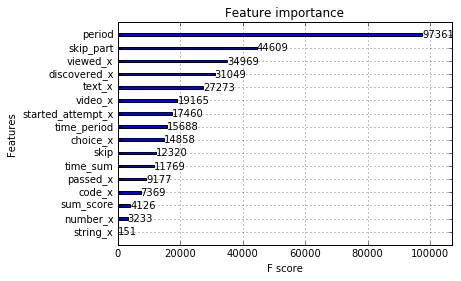

In [295]:
%pylab inline
xgb.plot_importance(bst)
pyplot.show()

In [296]:
for i in boost_pred.index.values:
    if boost_pred.ix[i, 0] >= 66:
        boost_pred.ix[i, 0] = 1
    else:
        boost_pred.ix[i, 0] = 0

In [297]:
f1_score(test_bi, boost_pred)

0.37647058823529411

## Random Forest

In [127]:
forest_regressor = sklearn.ensemble.RandomForestRegressor(n_estimators=40,
                                       criterion='mse',
                                       max_depth=None,
                                       min_samples_split=2,
                                       min_samples_leaf=1,
                                       min_weight_fraction_leaf=0.0,
                                       max_features='auto',
                                       max_leaf_nodes=None,
                                       bootstrap=True,
                                       oob_score=False,
                                       n_jobs=1,
                                       random_state=None)

In [128]:
forest_regressor.fit(train_data, train_labels)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [129]:
print forest_regressor.feature_importances_

[  1.33946466e-02   1.28034239e-02   2.25048467e-02   2.64815421e-02
   2.81762256e-02   1.24335378e-02   6.86927507e-03   1.88982699e-04
   2.82689522e-02   2.48430493e-02   1.59650166e-02   3.42992600e-02
   8.24834205e-02   5.17648560e-03   8.49114282e-03   5.42172769e-03
   8.32415483e-05   1.49220430e-02   7.63407054e-03   5.26170807e-01
   1.27156368e-02   6.52864737e-03   1.03610692e-02   1.32653099e-02
   1.02354175e-02   1.84012585e-02   1.14420237e-02   2.23550552e-02
   1.80838844e-02]


In [130]:
forest_pred = forest_regressor.predict(test_data)
forest_pred = pd.DataFrame(forest_pred)
forest_pred.columns = ['passed']
forest_pred[forest_pred.passed >= 65].shape

(217, 1)

In [131]:
for i in forest_pred.index.values:
    if forest_pred.ix[i, 0] >=65:
        forest_pred.ix[i, 0] = 1
    else:
        forest_pred.ix[i, 0] = 0

In [132]:
f1_score(test_bi, forest_pred)

0.44444444444444442

In [133]:
forest_regressor.feature_importances_

array([  1.33946466e-02,   1.28034239e-02,   2.25048467e-02,
         2.64815421e-02,   2.81762256e-02,   1.24335378e-02,
         6.86927507e-03,   1.88982699e-04,   2.82689522e-02,
         2.48430493e-02,   1.59650166e-02,   3.42992600e-02,
         8.24834205e-02,   5.17648560e-03,   8.49114282e-03,
         5.42172769e-03,   8.32415483e-05,   1.49220430e-02,
         7.63407054e-03,   5.26170807e-01,   1.27156368e-02,
         6.52864737e-03,   1.03610692e-02,   1.32653099e-02,
         1.02354175e-02,   1.84012585e-02,   1.14420237e-02,
         2.23550552e-02,   1.80838844e-02])

## голосование

In [317]:
gol_pred = []
for i in forest_pred.index.values:
    if forest_pred.ix[i, 0] + boost_pred.ix[i, 0] + pred_linear.ix[i, 0] >= 2:
        gol_pred += [1]
    else:
        gol_pred += [0]
gol_pred = pd.DataFrame(gol_pred)

In [318]:
f1_score(test_bi, gol_pred)

0.062499999999999986

# Тест

In [319]:
events = events_test

tmin1  = events.groupby('user_id').time.min()
tmax  = events.groupby('user_id').time.max()
tmin = tmax - tmin1

tmin1 = pd.DataFrame(tmin1)
tmin1.columns = ['start_time']
tmin1['user'] = tmin1.index


In [1125]:



events_last_week = events
events_last_week = pd.merge(events_last_week, tmin1, left_on='user_id', right_on='user', how='outer')
events_last_week = events_last_week[events_last_week.time > events_last_week.start_time + 604800]


In [1126]:
H_last = events_last_week.groupby('user_id') \
                    .apply(lambda x: x[['step_type']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)


H = events.groupby('user_id') \
                    .apply(lambda x: x[['step_type']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)

H_last['user_last'] = H_last.index


In [1127]:


steps = structure.step_id
steps = steps.tolist()


S = pasted_events.groupby('user_id') \
                    .apply(lambda x: x[['step_id']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)

S = S[steps]



H['skip'] = -1

H['skip_part'] = 0

In [1128]:



su = 0
k = 0
flag = 0
for i in S.index:
    for j in S.ix[i,:]:
        if j == 0 and flag == 1:
            flag = 0
            su += 1
        if j == 1 and flag == 0:
            flag = 1
    H.ix[i, 'skip'] = su
    su = 0
    flag = 0
su = 0
k = 0
flag = 0
tmp_su = 0
for i in S.index:
    ones = 0
    su = 0
    tmp_su = 0
    flag = 0
    for j in S.ix[i,:]:
        if j == 0 and flag == 1:
            flag = 0
            tmp_su = 1
        if j == 0 and flag == 0:
            tmp_su += 1
        if j == 1 and flag == 0:
            flag = 1
            su += tmp_su
            tmp_su = 0
        if j == 1:
            ones += 1  
        t = su / (su + ones + 0.00000000001) * 1.0
    H.ix[i, 'skip_part'] = t

In [1129]:

A = events.groupby('user_id') \
                    .apply(lambda x: x[['action']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)

A['user'] = A.index


A = pd.concat([A, H],axis=1)

tmin = pd.DataFrame(tmin)
tmin.columns = ['period']


A = pd.concat([A, tmin],axis=1)

A = pd.merge(A, H_last, left_on='user', right_on='user_last', how='outer')

A.index = A.user


In [1130]:


pasted_events = events[events.action == 'passed']

sum_score = pasted_events.groupby('user_id')['step_cost'].apply(lambda x: sum(x))
sum_score = pd.DataFrame(sum_score)
sum_score.columns = ['sum_score']

A = pd.concat([A, sum_score],axis=1)

pasted_events_last = events_last_week[events_last_week.action == 'passed']

In [1131]:

sum_score = pasted_events_last.groupby('user_id')['step_cost'].apply(lambda x: sum(x))
sum_score = pd.DataFrame(sum_score)
sum_score.columns = ['sum_score_last']


sum_score['user'] = sum_score.index

In [1132]:

A = pd.merge(A, sum_score, left_on='user', right_on='user', how='outer')

A_last = events_last_week.groupby('user_id') \
                    .apply(lambda x: x[['action']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)

In [1133]:

A_last['user'] = A_last.index


A = pd.merge(A, A_last, left_on='user', right_on='user', how='outer')

perc = A.passed_x / A.discovered_x * 1.0
perc = pd.DataFrame(perc, columns = ['perc']) 
A = pd.concat([A, perc],axis=1)
A.fillna(0, inplace = True)

In [1134]:
A.index = A.user

count_5 = events.groupby('user_id')['time'].apply(lambda x: count_work_5(x))
count_5 = pd.DataFrame(count_5)
count_5.columns = ['count_5']


A = pd.concat([A, count_5],axis=1)

In [1135]:
time_period = events.groupby('user_id')['time'].apply(lambda x: ave_time(x))
time_period = pd.DataFrame(time_period)
time_period.columns = ['time_period']

A = pd.concat([A, time_period],axis=1)

In [1136]:
A.fillna(0, inplace = True)

del A['user']
del A['user_last']


In [1155]:
features = []
for i in A.columns:
    features += [i]
users = A.index

In [1138]:


A_scaled = scaler.transform(A)
A_scaled = pd.DataFrame(A_scaled, columns = features)
A_scaled.index = users

In [1144]:
pred_linear.shape

(4255, 1)

In [1182]:
pred_linear = linear_regressor.predict(A_scaled)
pred_linear = pd.DataFrame(pred_linear, columns = ['passed'])
pred_linear[pred_linear.passed >= 61].shape

(174, 1)

In [1177]:
users = A.index

In [1183]:
for i in pred_linear.index.values:
    if pred_linear.ix[i, 0] >= 61:
        pred_linear.ix[i, 0] = 1
    else:
        pred_linear.ix[i, 0] = 0

In [1178]:
users = pd.DataFrame(users)

In [1180]:
users.columns = ['user_id']

In [1184]:
pred_linear = pd.concat([users, pred_linear],axis=1)

In [1185]:
pred_linear[:5]

,user_id,passed
0,5,0.0
1,9,0.0
2,21,0.0
3,26,0.0
4,29,1.0


In [1186]:
pred_linear.to_csv('lin_itog.csv', index=False)

In [1187]:
boost_pred = bst.predict(xgb.DMatrix(data = A_scaled))

In [1190]:
boost_pred = pd.DataFrame(boost_pred, columns = ['passed'])

In [1192]:
boost_pred[boost_pred.passed >= 64].shape

(196, 1)

In [1193]:
for i in boost_pred.index.values:
    if boost_pred.ix[i, 0] >= 64:
        boost_pred.ix[i, 0] = 1
    else:
        boost_pred.ix[i, 0] = 0

In [1194]:
boost_pred = pd.concat([users, boost_pred],axis=1)

In [1196]:
boost_pred[:7]

,user_id,passed
0,5,0.0
1,9,0.0
2,21,0.0
3,26,0.0
4,29,1.0
5,32,0.0
6,36,0.0


In [1197]:
boost_pred.to_csv('boost_itog.csv', index=False)

In [1214]:
forest_pred = forest_regressor.predict(A_scaled)
forest_pred = pd.DataFrame(forest_pred)
forest_pred.columns = ['passed']
forest_pred[forest_pred.passed >= 65].shape

(196, 1)

In [1215]:
for i in forest_pred.index.values:
    if forest_pred.ix[i, 0] >=65:
        forest_pred.ix[i, 0] = '1'
    else:
        forest_pred.ix[i, 0] = '0'

In [1216]:
forest_pred = pd.concat([users, forest_pred],axis=1)

In [1217]:
forest_pred[:3]

,user_id,passed
0,5,0
1,9,0
2,21,0


In [1218]:
forest_pred.to_csv('forest_itog.csv', index=False)

## голосование

In [1210]:
s1 = pd.read_csv('lin_itog.csv')
s2 = pd.read_csv('boost_itog.csv')
s3 = pd.read_csv('forest_itog.csv')


In [1211]:
for i in s1.index.values:
    if s1.ix[i, 1] + s2.ix[i, 1] + s3.ix[i, 1] >= 2:
        s1.ix[i, 1] = '1'
    else:
        s1.ix[i, 1] = '0'
s1[s1.passed == 0].shape

(0, 2)

In [1212]:
s1[s1.passed == '1'].shape

(188, 2)

In [1213]:
s1.to_csv('golos_itog.csv', index=False)

In [360]:
195.0/5000

0.039

In [198]:
targets.shape

(16625, 4)

In [171]:
targets[targets.passed == 1].shape

(659, 4)

In [199]:
659.0 / 16625

0.039639097744360904

In [174]:
targets.ix[users_train,:]

,user_id,score,passed,distinction
user_id,,,,
1,2,82,0,0
2,3,89,0,0
3,4,9,0,0
4,6,26,0,0
6,8,9,0,0
7,10,3,0,0
8,11,11,0,0
10,13,0,0,0
11,14,119,1,1


In [378]:
structure

,course_id,module_id,module_position,lesson_id,lesson_position,step_id,step_position,step_type,step_cost
0,7,17,1,2721,1,7225,1,text,0
1,7,17,1,2721,1,7230,2,text,0
2,7,17,1,2721,1,7231,3,text,0
3,7,17,1,2721,1,7232,4,text,0
4,7,17,1,2721,1,43604,5,text,0
5,7,17,1,2721,1,7233,6,text,0
6,7,17,1,2721,1,10828,7,text,0
7,7,17,1,531,2,2828,1,text,0
8,7,17,1,531,2,4848,2,video,0
9,7,17,1,531,2,4850,3,video,0


In [104]:
len(structure.groupby('step_id').step_cost.sum())

354